# Calculation of thermodynamics and kinetics in two-state models along conformational modes in free Ubiquitin
Note that paths to simulation data may need to be adjusted to fit your system

In [3]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
import pyemma
from os.path import isfile
import mdtraj as md
from msmtools.util.statistics import confidence_interval as CI

In [4]:
kbT_300K_kjmol = 2.495

In [5]:
apf = [np.load(f"ubq_nowater/pepflip_{i}.npz.npy") for i in range(18)]
ap = [np.load(f"ubq_nowater/pincer_mode_{i}.npz.npy") for i in range(18)]

# Pincer mode

In [6]:
km2 = pyemma.coordinates.cluster_kmeans(ap, k=2)

Show clusters and data histogram

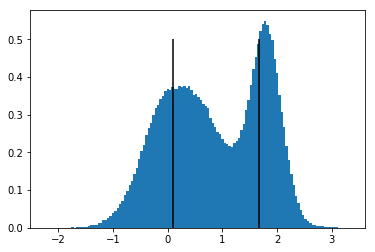

In [7]:
plt.hist(np.concatenate(ap),bins=128,density=True);
plt.vlines(km2.cluster_centers_.flatten(), ymin=0, ymax=0.5);

In [13]:
km2.cluster_centers_.flatten()

array([1.663215  , 0.10178986], dtype=float32)

Implied time-scales of two-state hidden Markov model.

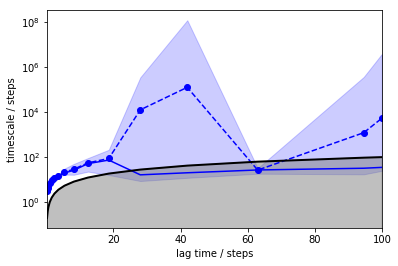

In [14]:
its_pincer = pyemma.msm.timescales_hmsm(km2.dtrajs,nstates=2,lags=500,errors='bayes',nsamples=1000)
pyemma.plots.plot_implied_timescales(its_pincer,dt=0.2)

In [15]:
mdl=its_pincer.models[8]

Lag time of selected model in nanoseconds

In [16]:
mdl.lag*0.2

8.200000000000001

Positions of cluster-center (lower value is open state)

In [17]:
km2.cluster_centers_.flatten()

array([1.663215  , 0.10178986], dtype=float32)

Compute exchange rates (averages and confidence intervals) in units of $s^{-1}$

In [18]:
mfpt_pincer_10=1e9/(np.array(mdl.sample_f('mfpt', 1,0))*0.2)
mfpt_pincer_01=1e9/(np.array(mdl.sample_f('mfpt', 0,1))*0.2)

In [19]:
np.mean(mfpt_pincer_01), CI(mfpt_pincer_01)

(16609426.873911925, (10948508.452159496, 24154233.21609639))

In [20]:
np.mean(mfpt_pincer_10), CI(mfpt_pincer_10)

(15053507.387638092, (7041292.4949383335, 24317167.965895064))

Compute $\Delta G$ (at 300K) and state populations (averages and confidence intervals) in units of $kJ\cdot \text{mol}^{-1}$ and unitless respectively.

In [21]:
stat_dists=mdl.sample_f('stationary_distribution_obs')

In [22]:
dgs = [-kbT_300K_kjmol*np.log(p[0]/p[1]) for p in stat_dists]

Compute population shifts in peptide flip mode (requires running analysis notebook first)

In [ ]:
xus=[p[0]/p[1] for p in stat_dists]

In [ ]:
xb=np.load("../model_analysis/xb.npy")

In [ ]:
np.mean(xus/xb[1000:]), CI(xus/xb[1000:]), 

In [23]:
np.mean(dgs),CI(dgs)

(0.08471049161768586, (-0.08013858299828504, 0.24487451996712634))

In [24]:
np.mean(stat_dists,axis=0),CI(stat_dists)

(array([0.4915154, 0.5084846]),
 (array([0.47554849, 0.49197028]), array([0.50810045, 0.52450484])))

## Peptide flip
Cluster and plot data and cluster-centers. Print values of cluster-centers -- lower is 'out' state.

In [18]:
km3 = pyemma.coordinates.cluster_kmeans(apf, k=2)

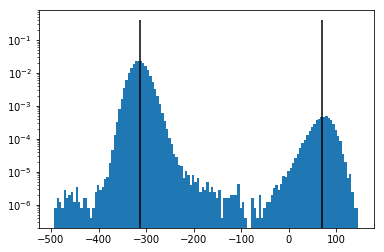

In [19]:
plt.hist(np.concatenate(apf),bins=128, log=True, density=True);
plt.vlines(km3.cluster_centers_.flatten(),ymin=0, ymax=0.4)

In [20]:
km3.cluster_centers_.flatten()

array([-313.75247 ,   69.097786], dtype=float32)

smaller is IN and larger is OUT (0 in/1 out)

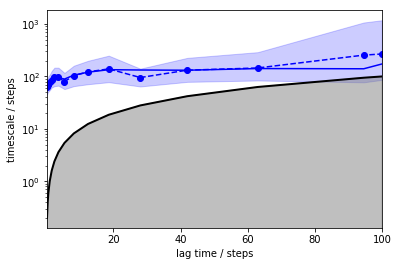

In [21]:
its_pflip = pyemma.msm.timescales_hmsm(km3.dtrajs,nstates=2,lags=500,errors='bayes',nsamples=1000)
pyemma.plots.plot_implied_timescales(its_pflip,dt=0.2)

In [22]:
#select model

In [23]:
mdl_pflip=its_pflip.models[8]

In [24]:
# compute stationary distribution for each sample and compute dG, sample mean and confidence intervals

In [25]:
stat_dists_pflip=mdl_pflip.sample_f('stationary_distribution_obs')

In [26]:
dgs = [-kbT_300K_kjmol*np.log(p[0]/p[1]) for p in stat_dists_pflip]

In [37]:
mdl_pflip.metastable_memberships[1]

array([0.02281036, 0.97718964])

In [38]:
np.mean(dgs),CI(dgs)

(-9.330239116985519, (-10.769012393128937, -7.8745791322337935))

Populations

In [39]:
np.mean(stat_dists_pflip, axis=0),CI(stat_dists_pflip)

(array([0.97589611, 0.02410389]),
 (array([0.95888565, 0.0134324 ]), array([0.98657037, 0.04125716])))

Exchange rates

In [40]:
mfpt_pflip_10=1e9/(np.array(mdl_pflip.sample_f('mfpt', 1,0))*0.2)
mfpt_pflip_01=1e9/(np.array(mdl_pflip.sample_f('mfpt', 0,1))*0.2)

In [41]:
np.mean(mfpt_pflip_10), CI(mfpt_pflip_10)

(9524933.172435291, (5941486.956577879, 14295180.555065537))

In [42]:
np.mean(mfpt_pflip_01), CI(mfpt_pflip_01)

(222819.60865184854, (136022.29060284383, 340392.050714745))

## C-term mode
Extract features and project on to tica-modes and cluster-centers from Ubq:SH3 simulations
please download these trajectories separately from the Edmond repository: https://doi.org/10.17617/3.8o

In [43]:
feat = pyemma.coordinates.featurizer('ubq_nowater/UbqAlone_Solv_0_eq_restart0_nowater.pdb')
feat.add_backbone_torsions(' or '.join([f'resi {i}' for i in range(69,76)]),cossin=True)


In [44]:
cterm_feats = pyemma.coordinates.load([f'ubq_nowater/traj{i}.xtc' for i in range(20) if i not in [11, 13]], feat)

In [45]:
tica_cterm = pyemma.load('../model_analysis/tica_cterm.pyemm')
km_cterm = pyemma.load('../model_analysis/cluster_tica_cterm.pyemma')

/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(name) as h5f:
/Users/solsson/miniconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [46]:
cterm_feats = [t[:,:2] for t in tica_cterm.transform(cterm_feats)]

In [47]:
dtrajs_cterm = km_cterm.assign(cterm_feats)

Implied time-scales of two-state hidden Markov models.

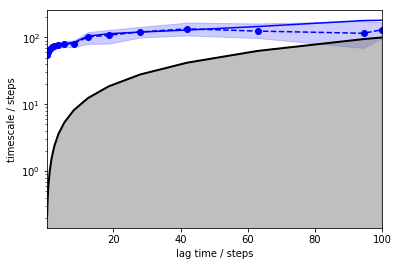

In [48]:
its_ct = pyemma.msm.timescales_hmsm(dtrajs_cterm,nstates=2,lags=500,errors='bayes',nsamples=1000)
pyemma.plots.plot_implied_timescales(its_ct,dt=0.2)

Select model and print out lag-time in nanoseconds

In [49]:
cterm_model = its_ct.models[10]

In [50]:
cterm_model.lag*0.2

18.6

Histogram of c-term mode and cluster centers (red are compact, cyan are extended)

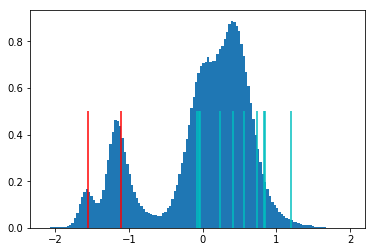

In [51]:
plt.hist(np.concatenate(cterm_feats)[:,0],bins=128,density=True);
plt.vlines(km_cterm.cluster_centers_[cterm_model.metastable_assignments==0,0], ymin=0, ymax=0.5, color='r');
plt.vlines(km_cterm.cluster_centers_[cterm_model.metastable_assignments==1,0], ymin=0, ymax=0.5, color='c');

Compute exchange rates (means and confidence intervals) in $s^{-1}$

In [52]:
mfpt_ct_10=1e9/(np.array(cterm_model.sample_f('mfpt', 1,0))*0.2)
mfpt_ct_01=1e9/(np.array(cterm_model.sample_f('mfpt', 0,1))*0.2)

In [53]:
np.mean(mfpt_ct_10), CI(mfpt_ct_10)

(1781416.8045597684, (1434804.9495208114, 2396978.8048897902))

In [54]:
np.mean(mfpt_ct_01), CI(mfpt_ct_01)

(6795421.6930258395, (5516769.015190309, 8853848.521914564))

Compute $\Delta G$ (at 300K) and state populations (means and confidence intervals) in $kJ\cdot \text{mol}^{-1}$ and no units, respectively.

In [55]:
stat_dists_ct=cterm_model.sample_f('stationary_distribution')

In [56]:
dgs = [-kbT_300K_kjmol*np.log(p[0]/p[1]) for p in stat_dists_ct]

In [57]:
print(f"dG {np.mean(dgs)} CI[{CI(dgs)}]")

dG 3.343387522950439 CI[(2.7612200071875743, 3.910470736289139)]


In [68]:
np.mean(stat_dists_ct, axis=0)

array([0.20820241, 0.79179759])

In [69]:
CI(stat_dists_ct)

(array([0.17281626, 0.75085315]), array([0.24914792, 0.82740031]))

### Joint clustering of C-term and pincer

In [ ]:
pinc_ct = [np.vstack([a,c[:,0]]).T for a,c in zip(ap, cterm_feats)]

In [ ]:
cluster_pinc_ct = pyemma.coordinates.cluster_kmeans(pinc_ct, k=32)

In [ ]:
plt.hist2d(np.concatenate(ap), np.concatenate(cterm_feats)[:,0], bins=128, norm=mpl.colors.LogNorm());
plt.scatter(*cluster_pinc_ct.cluster_centers_.T)

In [ ]:
hmm_ct_pinc_its = pyemma.msm.timescales_hmsm(cluster_pinc_ct.dtrajs, nstates=4, lags=[1,5,10,20,30])

In [ ]:
pyemma.plots.plot_implied_timescales(hmm_ct_pinc_its)

In [ ]:
bhmm_ct_pinc_ = pyemma.msm.bayesian_hidden_markov_model(cluster_pinc_ct.dtrajs, nstates=4, lag=20,nsamples=2000)

In [ ]:
plt.hist2d(np.concatenate(ap), np.concatenate(cterm_feats)[:,0], bins=128, norm=mpl.colors.LogNorm());
plt.scatter(*cluster_pinc_ct.cluster_centers_.T, c=[f"C{i}" for i in bhmm_ct_pinc_.metastable_assignments])
for i in range(4):
    plt.text(cluster_pinc_ct.cluster_centers_[bhmm_ct_pinc_.metastable_assignments==i, 0].mean(),
             cluster_pinc_ct.cluster_centers_[bhmm_ct_pinc_.metastable_assignments==i, 1].mean(),
             f"Metastable {i}", color=f'C{i}', fontsize=10,
             #transform=plt.gca().transAxes,
            horizontalalignment='center',
             verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

In [ ]:
nb_to_b = 1e9/(np.array(bhmm_ct_pinc_.sample_f('mfpt', 0, 2))*0.2)
b_to_nb = 1e9/(np.array(bhmm_ct_pinc_.sample_f('mfpt', 2, 0))*0.2)

In [ ]:
print(np.mean(nb_to_b), CI(nb_to_b))
print(np.mean(b_to_nb), CI(b_to_nb))

In [ ]:
bhmm_ct_pinc_.stationary_distribution[[0,2]]/bhmm_ct_pinc_.stationary_distribution[[0,2]].sum()

In [ ]:
bhmm_ct_pinc_.metastable_memberships.argmax(axis=0)

In [ ]:
source_ = pyemma.coordinates.source([f'ubq_nowater/traj{i}.xtc' for i in range(20) if i not in [11, 13]], feat)

a


In [71]:
np.concatenate(ap).shape

(507139,)